In [57]:
from limpeza_padronizacao import *
from pipelines.pipeline_meteostat_diario import acessar_csv_s3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder

### Obtendo os dados meteorológicos do S3

In [58]:
bucket_name = 'black-umbrella-fiap'
object_key = 'bronze/meteostat_diario/historico_diario_1950_2024.csv'

In [59]:
df_meteo = acessar_csv_s3(bucket_name, object_key)

In [60]:
df_meteo

,index,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,Distrito,Latitude,Longitude
0,1950-01-01,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Água Rasa,-23.565372,-46.573697
1,1950-01-02,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Água Rasa,-23.565372,-46.573697
2,1950-01-03,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Água Rasa,-23.565372,-46.573697
3,1950-01-04,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Água Rasa,-23.565372,-46.573697
4,1950-01-05,NaN,NaN,NaN,29.3,NaN,NaN,NaN,NaN,NaN,NaN,Água Rasa,-23.565372,-46.573697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2559634,2024-09-10 00:00:00,24.3,18.2,30.1,0.0,NaN,132.0,7.2,NaN,1012.4,NaN,Vila Medeiros,-23.487707,-46.584496
2559635,2024-09-10 00:00:00,24.4,18.2,30.4,0.0,NaN,50.0,8.2,NaN,1012.0,NaN,Vila Prudente,-23.592335,-46.574961
2559636,2024-09-10 00:00:00,24.4,18.2,30.4,0.0,NaN,50.0,8.2,NaN,1012.0,NaN,Vila Sônia,-23.598656,-46.739294
2559637,2024-09-10 00:00:00,24.3,18.2,30.1,0.0,NaN,132.0,7.2,NaN,1012.4,NaN,São Domingos,-23.493876,-46.742194


In [117]:
dados_meteo = df_meteo.copy()

In [118]:
dados_meteo = dados_meteo.drop(columns=['snow', 'wpgt', 'tsun'])

In [124]:
# Padronizar nomes das colunas: remover espaços, substituir por sublinhados e converter para minúsculas
dados_meteo.columns = [unidecode.unidecode(col.strip().replace(' ', '_').lower()) for col in dados_meteo.columns]

# Remover coluna 'unnamed:_0' se existir
if 'unnamed:_0' in dados_meteo.columns:
    dados_meteo = dados_meteo.drop(columns=['unnamed:_0'])

# Normalizar texto em colunas de string: remover espaços em branco ao redor e padronizar para título
for col in dados_meteo.select_dtypes(include='object').columns:
    dados_meteo[col] = dados_meteo[col].str.strip().str.title()

# Remover acentuações dos dados de texto para padronização
dados_meteo = dados_meteo.applymap(lambda x: unidecode.unidecode(x) if isinstance(x, str) else x)

In [125]:
dados_meteo

,index,tavg,tmin,tmax,prcp,wdir,wspd,pres,distrito,latitude,longitude
0,1950-01-01,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Agua Rasa,-23.565372,-46.573697
1,1950-01-02,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Agua Rasa,-23.565372,-46.573697
2,1950-01-03,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Agua Rasa,-23.565372,-46.573697
3,1950-01-04,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Agua Rasa,-23.565372,-46.573697
4,1950-01-05,NaN,NaN,NaN,29.3,NaN,NaN,NaN,Agua Rasa,-23.565372,-46.573697
...,...,...,...,...,...,...,...,...,...,...,...
2559634,2024-09-10 00:00:00,24.3,18.2,30.1,0.0,132.0,7.2,1012.4,Vila Medeiros,-23.487707,-46.584496
2559635,2024-09-10 00:00:00,24.4,18.2,30.4,0.0,50.0,8.2,1012.0,Vila Prudente,-23.592335,-46.574961
2559636,2024-09-10 00:00:00,24.4,18.2,30.4,0.0,50.0,8.2,1012.0,Vila Sonia,-23.598656,-46.739294
2559637,2024-09-10 00:00:00,24.3,18.2,30.1,0.0,132.0,7.2,1012.4,Sao Domingos,-23.493876,-46.742194


In [91]:
dados_meteo.dtypes

index         object
tavg         float64
tmin         float64
tmax         float64
prcp         float64
wdir         float64
wspd         float64
pres         float64
distrito      object
latitude     float64
longitude    float64
dtype: object

In [92]:
dados_meteo['prcp'].max()

72.1

### Obtendo os dados de ocorrências do S3

In [93]:
bucket_name = 'black-umbrella-fiap'
object_key = 'bronze/ocorrencias/ocorrencias_com_distritos.csv'

In [94]:
df_ocorr = acessar_csv_s3(bucket_name, object_key)

In [95]:
dados_ocorr = df_ocorr.copy()

In [98]:
dados_ocorr

,data,ocorrencia,subprefeit,geometry,distrito,longitude,latitude
0,2013-12-29 00:00:00,Queda De Arvore,Bt - Butanta,Point Z (318923.7137000401 7389107.424428364 0),Raposo Tavares,-46.774643,-23.598443
1,2013-12-03 00:00:00,Queda De Arvore,Cs - Capela Do Socorro,Point Z (326291.0101464727 7378438.554415315 0),Socorro,-46.703712,-23.695577
2,2013-12-10 00:00:00,Alagamento,Sa - Santo Amaro,Point Z (325784.8790245799 7383070.030224832 0),Santo Amaro,-46.708130,-23.653706
3,2013-12-30 00:00:00,Queda De Arvore,Se - Se,Point Z (332913.13708172296 7396238.345912354 0),Republica,-46.636786,-23.535563
4,2013-12-29 00:00:00,Queda De Arvore,Sa - Santo Amaro,Point Z (325940.60835598 7385402.683087114 0),Santo Amaro,-46.706331,-23.632662
...,...,...,...,...,...,...,...
58147,2024-01-31 00:00:00,Alagamento,Sb - Sapopemba,Point (347483.63164646423 7386553.45190624),Sapopemba,-46.495083,-23.624450
58148,2024-01-31 00:00:00,Queda De Arvore,Iq - Itaquera,Point (354127.125688214 7394828.660900325),Jose Bonifacio,-46.429165,-23.550340
58149,2024-01-31 00:00:00,Inundacao,Cs - Capela Do Socorro,Point (328375.1026824678 7375680.958841767),Cidade Dutra,-46.683598,-23.720698
58150,2024-01-31 00:00:00,Queda De Arvore,Bt - Butanta,Point (324562.933228591 7390714.9646354485),Butanta,-46.719206,-23.584550


In [72]:
dados_ocorr.dtypes

data           object
ocorrencia     object
subprefeit     object
name            int64
geometry       object
latitude      float64
longitude     float64
dtype: object

____

## Daqui pra baixo foram feitos apenas testes, nao considerar como versão final

### Início Integração dos dados

___

## ACHO QUE AQUI VAI DAR BOM

In [126]:
ocorrencias = dados_ocorr.copy()
meteorologia = dados_meteo.copy()

In [127]:
meteorologia = meteorologia.rename(columns={'index': 'data'})

In [128]:
meteorologia['data'] = pd.to_datetime(meteorologia['data'], format='mixed')  # ajuste conforme o nome da sua coluna de data
ocorrencias['data'] = pd.to_datetime(ocorrencias['data'], format='mixed')

In [193]:
# Realizar o merge com a base meteorológica
base_final = pd.merge(meteorologia, ocorrencias, how='outer', on=['data', 'distrito'])

In [194]:
base_final = base_final[base_final['data'].dt.year >= 2013]

In [217]:
pd.set_option('display.max_rows', 10)
base_final

,data,tavg,tmin,tmax,prcp,wdir,wspd,pres,distrito,latitude_x,longitude_x,ocorrencia
2158165,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,1017.517679,Agua Rasa,-23.565372,-46.573697,NaN
2158166,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,1017.517679,Alto De Pinheiros,-23.549906,-46.707642,NaN
2158167,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,1017.517679,Anhanguera,-23.432908,-46.788534,NaN
2158168,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,1017.517679,Aricanduva,-23.578024,-46.511454,NaN
2158169,2013-01-01,29.6,20.0,31.0,0.0,315.0,11.1,1017.517679,Artur Alvim,-23.540469,-46.489791,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2580674,2024-09-10,24.4,18.2,30.4,0.0,50.0,8.2,1012.000000,Vila Mariana,-23.583700,-46.632741,NaN
2580675,2024-09-10,24.2,16.6,32.7,0.0,5.0,10.8,1014.700000,Vila Matilde,-23.536179,-46.524605,NaN
2580676,2024-09-10,24.3,18.2,30.1,0.0,132.0,7.2,1012.400000,Vila Medeiros,-23.487707,-46.584496,NaN
2580677,2024-09-10,24.4,18.2,30.4,0.0,50.0,8.2,1012.000000,Vila Prudente,-23.592335,-46.574961,NaN


In [196]:
base_final['ocorrencia'].notnull().sum()

53826

In [197]:
base_final = base_final.drop(columns=['subprefeit', 'geometry', 'longitude_y', 'latitude_y'])

In [207]:
missings_por_coluna = base_final.isna().sum()
missings_por_coluna = pd.DataFrame(missings_por_coluna, columns=['n']).reset_index().rename(columns={'index': 'variaveis'})
missings_por_coluna

,variaveis,n
0,data,0
1,tavg,0
2,tmin,0
3,tmax,0
4,prcp,0
5,wdir,0
6,wspd,0
7,pres,0
8,distrito,0
9,latitude_x,1004


In [203]:
base_final.describe()

,data,tavg,tmin,tmax,prcp,wdir,wspd,pres,latitude_x,longitude_x
count,422514,420858.000000,412511.000000,412147.000000,279384.000000,391382.000000,411315.000000,302960.000000,421510.000000,421510.000000
mean,2018-11-12 02:57:48.257146880,21.323706,16.638833,25.777328,3.865668,147.478290,11.072096,1017.517679,-23.557607,-46.605534
min,2013-01-01 00:00:00,7.100000,1.000000,8.000000,0.000000,0.000000,0.000000,894.900000,-23.908391,-46.788534
25%,2015-12-30 00:00:00,18.700000,14.400000,23.000000,0.000000,87.000000,8.500000,1014.700000,-23.596499,-46.701939
50%,2018-11-25 00:00:00,21.400000,17.000000,26.000000,0.000000,126.000000,10.800000,1017.400000,-23.551530,-46.638164
75%,2021-10-10 00:00:00,24.000000,19.000000,29.000000,3.000000,172.000000,13.500000,1020.500000,-23.510151,-46.537791
max,2024-09-10 00:00:00,36.300000,25.900000,39.000000,189.000000,360.000000,31.600000,1032.000000,-22.957140,-45.547526
std,NaN,3.882373,3.316193,4.354250,9.509959,97.363137,3.899602,5.276243,0.100620,0.153865


In [206]:
base_final['prcp'] = base_final['prcp'].fillna(0)
base_final['wdir'] = base_final['wdir'].fillna(base_final['wdir'].mean())
base_final['wspd'] = base_final['wspd'].fillna(base_final['wspd'].mean())
base_final['tavg'] = base_final['tavg'].fillna(base_final['tavg'].mean())
base_final['tmin'] = base_final['tmin'].fillna(base_final['tmin'].mean())
base_final['tmax'] = base_final['tmax'].fillna(base_final['tmax'].mean())
base_final['pres'] = base_final['pres'].fillna(base_final['pres'].mean())

In [210]:
base_final

,data,tavg,tmin,tmax,prcp,wdir,wspd,pres,distrito,latitude_x,longitude_x,ocorrencia
2158165,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,1017.517679,Agua Rasa,-23.565372,-46.573697,NaN
2158166,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,1017.517679,Alto De Pinheiros,-23.549906,-46.707642,NaN
2158167,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,1017.517679,Anhanguera,-23.432908,-46.788534,NaN
2158168,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,1017.517679,Aricanduva,-23.578024,-46.511454,NaN
2158169,2013-01-01,29.6,20.0,31.0,0.0,315.0,11.1,1017.517679,Artur Alvim,-23.540469,-46.489791,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2580674,2024-09-10,24.4,18.2,30.4,0.0,50.0,8.2,1012.000000,Vila Mariana,-23.583700,-46.632741,NaN
2580675,2024-09-10,24.2,16.6,32.7,0.0,5.0,10.8,1014.700000,Vila Matilde,-23.536179,-46.524605,NaN
2580676,2024-09-10,24.3,18.2,30.1,0.0,132.0,7.2,1012.400000,Vila Medeiros,-23.487707,-46.584496,NaN
2580677,2024-09-10,24.4,18.2,30.4,0.0,50.0,8.2,1012.000000,Vila Prudente,-23.592335,-46.574961,NaN


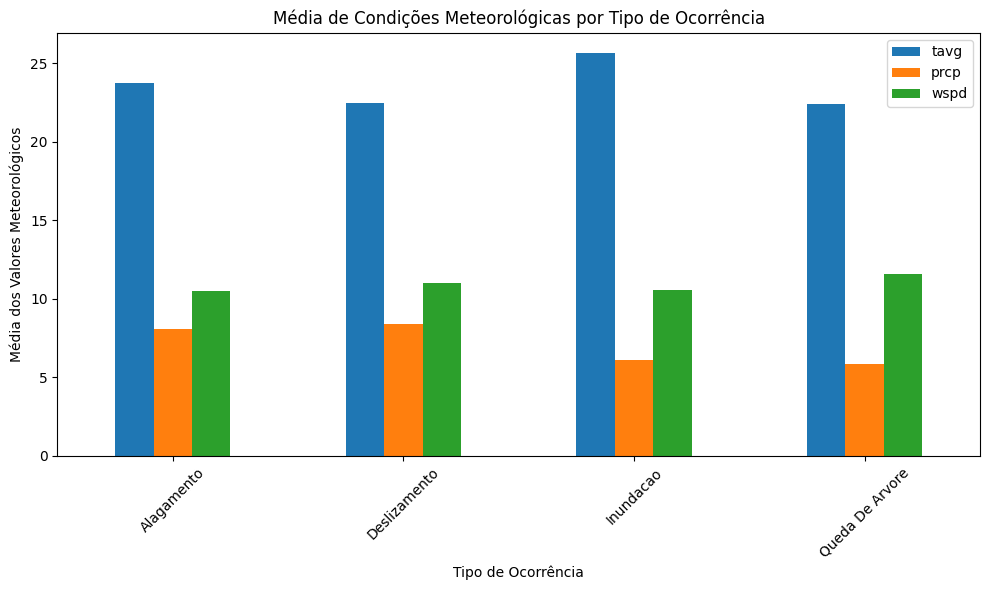

In [216]:
# Selecionando as colunas meteorológicas numéricas
colunas_meteorologicas = ['tavg', 'prcp', 'wspd']

# Removendo linhas com todas as colunas meteorológicas NaN
ocorrencias_clean = base_final.dropna(subset=colunas_meteorologicas, how='all')

# Agrupando por tipo de ocorrência e calculando a média das colunas meteorológicas
ocorrencias_meteorologicas = ocorrencias_clean.groupby('ocorrencia')[colunas_meteorologicas].mean()

# Plotando um gráfico de barras
ocorrencias_meteorologicas.plot(kind='bar', figsize=(10,6))
plt.title('Média de Condições Meteorológicas por Tipo de Ocorrência')
plt.ylabel('Média dos Valores Meteorológicos')
plt.xlabel('Tipo de Ocorrência')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()